# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize #Aditya
import datetime
import os
import matplotlib.pyplot as plt
from skimage import exposure
import random
from skimage import transform

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

# For local
# train_doc = np.random.permutation(open('Project_data/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('Project_data/Project_data/val.csv').readlines())

batch_size = 3 #experiment with the batch size
img_size = 150 #update
interval = [10,12,14,15,17,19,21,23,25,27]
frame_count=30

NUM_CLASSES = 5
filtersize = (2, 2, 2)
dense_neurons = 64
dropout = 0.5
input_shape = (len(interval),img_size,img_size,3)

In [5]:
def normalize(image):
    image = image.astype('float32')
    
    return (image - np.min(image))/(np.max(image) - np.min(image))

In [6]:
def rotate(image, deg):
    shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

    # translation by certain units
    matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
    matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

    # rotation
    rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(deg))
    rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
    rot_image = transform.warp(image, rot_matrix)
    return rot_image

In [7]:
def crop(image):
    w, h, _ = image.shape
    crop = 0

    if (h > 200):
        crop = 30
        image[:crop, :] = 0
        image[-1:-crop, :] = 0

    image = image[crop:h - crop, crop:w-crop, : ]
    return image

In [8]:
def adjust_exposure(image, gamma):
    return exposure.adjust_gamma(image, gamma=0.2)

In [9]:
def resize(image, size = img_size):
    return imresize(image, size=(size,size))

In [10]:
def randomize(sequences, labels):
#     zipped = list(zip(sequences, labels))
#     random.shuffle(zipped)
#     batch_data, batch_labels = zip(*zipped)
    
    indices = np.arange(labels.shape[0])
    np.random.shuffle(indices)
    sequences = sequences[indices]
    labels = labels[indices]
    
    return sequences, labels

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size, ablation_size = 0, augmentation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = interval#update #Aditya  #create a list of image numbers you want to use for a particular video
    
    if ablation_size is not 0:
        folder_list = folder_list[:ablation_size]
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size #Aditya # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = img_size
            z = img_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data_aug = np.zeros((batch_size,x,y,z,3))
            batch_data_rot = np.zeros((batch_size,x,y,z,3))
                        
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            gamma = np.random.uniform(low=0.2, high=0.9)
            rotation_angle = random.choice([-10,10])
                        
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(crop(image))
                    
                    if augmentation:
                        image_aug = adjust_exposure(image, gamma=gamma)
                        rot_image = rotate(image, rotation_angle)
                                        
                    batch_data[folder,idx,:,:,0] = normalize(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize(image[:,:,2])
                
                    if augmentation:                        
                        batch_data_aug[folder,idx,:,:,0] = normalize(image_aug[:,:,0])
                        batch_data_aug[folder,idx,:,:,1] = normalize(image_aug[:,:,1])
                        batch_data_aug[folder,idx,:,:,2] = normalize(image_aug[:,:,2])

                        batch_data_rot[folder,idx,:,:,0] = normalize(rot_image[:,:,0])
                        batch_data_rot[folder,idx,:,:,1] = normalize(rot_image[:,:,1])
                        batch_data_rot[folder,idx,:,:,2] = normalize(rot_image[:,:,2])
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            batch_data1, batch_labels1 = randomize(np.concatenate([batch_data, batch_data_aug, batch_data_rot]), np.concatenate([batch_labels, batch_labels]))
                
            if augmentation:
                batch_data, batch_labels = randomize(np.concatenate([batch_data, batch_data_aug, batch_data_rot]), np.concatenate([batch_labels, batch_labels]))
                yield batch_data, batch_labels
            else:
                yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches
        remainder = len(t) % batch_size
        if(remainder != 0):
            x = len(img_idx)
            y = img_size
            z = img_size
            batch_data = np.zeros((remainder,x,y,z,3))
            batch_data_aug = np.zeros((remainder,x,y,z,3))
            
            batch_labels = np.zeros((remainder, 5))
            
            gamma = np.random.uniform(low=0.3, high=0.9)
            rotation_angle = random.choice([-10,10])
            t = t[-remainder:]
            for folder in range(remainder): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+ imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(crop(image))
                    
                    if augmentation:
                        image_aug = adjust_exposure(image, gamma=gamma)
                        rot_image = rotate(image, rotation_angle)
                                        
                    batch_data[folder,idx,:,:,0] = normalize(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize(image[:,:,2])
                
                    if augmentation:                        
                        batch_data_aug[folder,idx,:,:,0] = normalize(image_aug[:,:,0])
                        batch_data_aug[folder,idx,:,:,1] = normalize(image_aug[:,:,1])
                        batch_data_aug[folder,idx,:,:,2] = normalize(image_aug[:,:,2])

                        batch_data_rot[folder,idx,:,:,0] = normalize(rot_image[:,:,0])
                        batch_data_rot[folder,idx,:,:,1] = normalize(rot_image[:,:,1])
                        batch_data_rot[folder,idx,:,:,2] = normalize(rot_image[:,:,2])
                    
                batch_labels[folder, int(t[folder].strip().split(';')[2])] = 1
            
            if augmentation:
                batch_data, batch_labels = randomize(np.concatenate([batch_data, batch_data_aug, batch_data_rot]), np.concatenate([batch_labels, batch_labels]))
                yield batch_data, batch_labels
            else:
                yield batch_data, batch_labels

Source path =  Project_data/train ; batch size = 3


C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


[0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]


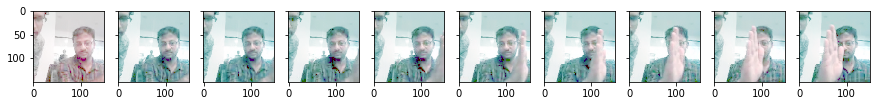

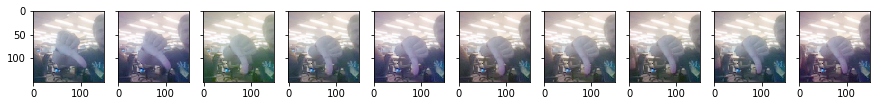

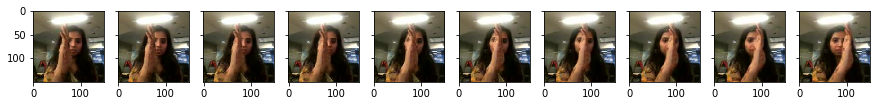

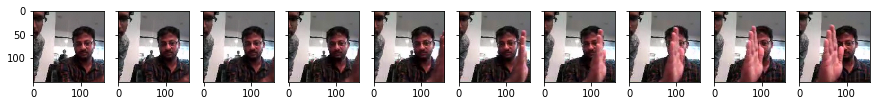

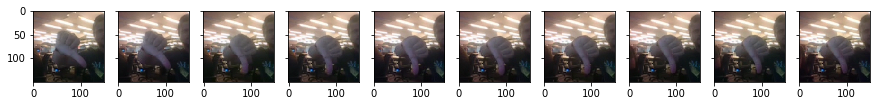

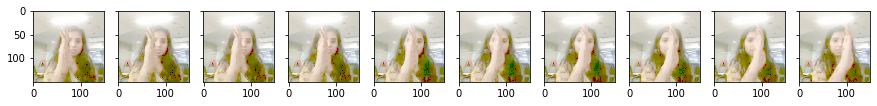

In [12]:
train_path = 'Project_data/train'
test_images_generator = generator(train_path, train_doc, batch_size, ablation_size=3, augmentation=True)

test_images = []
counter = 0
for test_img in test_images_generator:
    for vdo,label in zip(test_img[0],test_img[1]):
#         print(vdo.shape)
        print(label)
        plot_image(vdo)
    break;
    
    counter = counter + 1
    if counter is 50:
        break;

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
# curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = # choose the number of epochs
# print ('# epochs =', num_epochs)

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras import optimizers

# #write your model here
# #Aditya

# NUM_CLASSES = 5

# # With Conv3D
# input_shape = (len(interval),img_size,img_size,3)
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(2, 3, 3), activation='relu', padding='same', input_shape=input_shape))
# model.add(Conv3D(32, kernel_size=(2, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# # model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Conv3D(64, kernel_size=(2, 3, 3), activation='relu'))
# model.add(Conv3D(64, kernel_size=(2, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Dropout(0.25))

# # model.add(Conv3D(128, kernel_size=(2, 3, 3), activation='relu', padding='same'))
# # model.add(Conv3D(128, kernel_size=(2, 3, 3), activation='relu', padding='same'))
# # model.add(Dropout(0.25))

# model.add(Flatten())

# # model.add(Dense(264, activation='relu'))
# # model.add(Dropout(0.25))

# # model.add(Dense(264, activation='relu'))
# # model.add(Dropout(0.25))

# model.add(Dense(NUM_CLASSES, activation='softmax'))

# print (model.summary())

In [15]:
len(interval)

10

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

#write your model here
#Aditya




model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',
         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))



model.add(Flatten())
# model.add(Dense(dense_neurons,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))


model.add(Dense(NUM_CLASSES,activation='softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
#     activation='relu', padding='same'), input_shape=input_shape))
# model.add(TimeDistributed(Conv2D(32, (3,3),
#     kernel_initializer="he_normal", activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(64, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(128, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(128, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(256, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(256, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(512, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(512, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Flatten()))

# model.add(Dropout(0.5))
# model.add(LSTM(256, return_sequences=False, dropout=0.5))
# model.add(Dense(NUM_CLASSES, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [18]:
learning_rate = 0.0002
optimiser = optimizers.Adam(lr=learning_rate) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 150, 150, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 150, 150, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 150, 150, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 75, 75, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 75, 75, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 5, 75, 75, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 75, 75, 32)     128       
________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.0001)# write the REducelronplateau code here

ES = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    mode="auto",
    verbose=1
)

callbacks_list = [checkpoint, LR, ES]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
# # Try ablation

# train_generator = generator(train_path, train_doc, batch_size, ablation_size=100)
# val_generator = generator(val_path, val_doc, batch_size)

# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [22]:
# Ablation shows good improvement. Lets run for entire train data

train_generator = generator(train_path, train_doc, batch_size, augmentation=True)
val_generator = generator(val_path, val_doc, batch_size)

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1, initial_epoch=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Source path =  Project_data/val ; batch size = 3
Source path = Epoch 1/50
 Project_data/train ; batch size = 3


C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


  2/221 [..............................] - ETA: 22:58 - loss: 2.4345 - categorical_accuracy: 0.1667

KeyboardInterrupt: 